In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

from ase import Atoms
from ase.visualize import view
from ase.build import make_supercell
from ase.io import read

from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
import os
from mp_api.client import MPRester
from ase.io import write
from pymatgen.io.ase import AseAtomsAdaptor

load_dotenv()

API_KEY=os.getenv("MP_API_KEY")

def save_material_ids(output_file="material_ids.txt", max_results=100000, page_size=1000):
    with MPRester(API_KEY) as mpr, open(output_file, "w") as f:
        total_fetched = 0
        page = 0

        while total_fetched < max_results:
            results = mpr.materials.search(all_fields=False)

            if not results:
                break

            for entry in results:
                f.write(f"{entry.material_id},{entry.formula_pretty}\n")

            total_fetched += len(results)
            page += 1

        print(f"Saved {total_fetched} materials to {output_file}")
def get_atoms(id):
    with MPRester(API_KEY) as mpr:
        structure = mpr.get_structure_by_material_id(id)
        
        atoms = AseAtomsAdaptor.get_atoms(structure)
        
        return atoms
    
# save_material_ids()

/storage/home/hcoda1/7/jshim87/.conda/envs/graph_partitioning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Helper for converting atoms into respective model format (orb or mattersim)

In [3]:
from orb_models.forcefield.atomic_system import ase_atoms_to_atom_graphs
from mattersim.datasets.utils.convertor import GraphConvertor

mattersim_converter = GraphConvertor("m3gnet", 5.0, True, 4.0)

def atoms_to_graph_orb(atoms):
    graph = ase_atoms_to_atom_graphs(atoms)
    senders = graph.senders
    receivers = graph.receivers
    edge_feats = graph.edge_features

    G = nx.Graph()
    G.add_nodes_from(range(graph.n_node))
    G.graph['edge_weight_attr'] = 'weight'
    
    min_dist = min(edge_feats['r'])

    for i, u in enumerate(senders):
        G.add_edge(u.item(), receivers[i].item(), weight=int(edge_feats['r'][i] / min_dist * 1000))

    return G 

def atoms_to_graph_mattersim(atoms):
    return to_networkx(mattersim_converter.convert(atoms, None, None, None))

Helpers for retrieving relevant metrics from partition

In [4]:
def total_node_count(G, partitions, extended_partitions):
    """
    Returns the total number of nodes including overlapping nodes in extended
    partitions
    """
    
    return sum(len(x) for x in extended_partitions)

def root_node_count(G, partitions, extended_partitions):
    """
    Returns the total number of root nodes (the number of vertices in the
    original graph)
    """
    
    return sum(len(x) for x in partitions)

def extended_ratio(G, partitions, extended_partitions):
    """
    Returns the ratio of extended nodes to the total number of nodes (higher 
    ratio means more neighbors were captured in the partition, which we don't
    want)
    
    i.e. how many of our nodes are 'redundant'?
    """
    
    root = root_node_count(G, partitions, extended_partitions)
    total = total_node_count(G, partitions, extended_partitions)
    
    return (total - root) / (total)

def core_partition_stats(G, partitions, extended_partitions):
    """
    Returns statistics about the extended partitions (max, min, mean, std, 
    range)
    """
    
    partition_sizes = [len(p) for p in partitions]
    sizes = np.array(partition_sizes)
    
    return sizes.max(), sizes.min(), sizes.mean(), sizes.std(), (sizes.max() - sizes.mean())

def extended_partition_stats(G, partitions, extended_partitions):
    """
    Returns statistics about the extended partitions (max, min, mean, std, 
    range)
    """
    
    partition_sizes = [len(p) for p in extended_partitions]
    sizes = np.array(partition_sizes)
    
    return sizes.max(), sizes.min(), sizes.mean(), sizes.std(), (sizes.max() - sizes.mean())

def num_cut_edges(G, partitions, extended_partitions):
    """
    Returns the number of edges that were cut between partitions
    """
    
    node_to_part = {}
    for i, part in enumerate(partitions):
        for node in part:
            node_to_part[node] = i

    cut_edges = set()

    # Check each edge to see if it crosses partitions
    for u, v in G.edges():
        pu = node_to_part.get(u)
        pv = node_to_part.get(v)
        if pu is not None and pv is not None and pu != pv:
            cut_edges.add(tuple(sorted((u, v))))

    return len(cut_edges)

def sum_cut_edge_weights(G, partitions, extended_partitions):
    """
    For all cut edges, return sum(x) where x is the weight of each edge
    """
    
    cut_edges = set()
    node_to_partition = {node: i for i, part in enumerate(partitions) for node in part}
    for u, v in G.edges():
        if node_to_partition.get(u) != node_to_partition.get(v):
            cut_edges.add(tuple(sorted((u, v))))
    return sum(G.edges[u, v].get('weight', 0.0) for u, v in cut_edges)

def sum_inverse_cut_edge_weights(G, partitions, extended_partitions):
    """
    For all cut edges, return sum(1/x) where x is the weight of each edge
    
    Maybe minimizing this quantity will help because that means we are
    cutting fewer edges of atoms that are closer together (and thus
    more likely to have a greater impact on each other)
    """
    
    cut_edges = set()

    node_to_partition = {}
    for i, part in enumerate(partitions):
        for node in part:
            node_to_partition[node] = i

    for u, v in G.edges():
        p_u = node_to_partition.get(u)
        p_v = node_to_partition.get(v)
        if p_u is not None and p_v is not None and p_u != p_v:
            cut_edges.add(tuple(sorted((u, v))))

    # Sum inverse of edge weights for cut edges
    total_inverse_weight = 0.0
    for u, v in cut_edges:
        w = G.edges[u, v].get('weight', None)
        if w is not None and w > 0:
            total_inverse_weight += 1.0 / (w)

    return total_inverse_weight

Helper for running the benchmark and recording metrics

In [5]:
from partitioning import part_spectral, part_metis, part_grid, part_metis_unweighted

def benchmark_trial_orb(atoms, distance=1, granularity=2):
    G = atoms_to_graph_orb(atoms)
    
    print(len(G.edges))

    extended_partition_results = []
    results = []

    for method_name, partition_fn in [
        ("metis", part_metis),
        ("spectral", part_spectral),
        ("grid", part_grid),
        ("metis_unweighted", part_metis_unweighted)
    ]:
        if method_name == 'spectral' and len(atoms) >= 10000:
            continue
        
        try:
            partitions, extended_partitions = partition_fn(atoms, G, granularity ** 3, distance=distance)

            # Core stats
            core_max, core_min, core_mean, core_std, core_range = core_partition_stats(G, partitions, extended_partitions)
            # Extended stats
            ext_max, ext_min, ext_mean, ext_std, ext_range = extended_partition_stats(G, partitions, extended_partitions)

            result = {
                'method': method_name,
                'node_count': total_node_count(G, partitions, extended_partitions),
                'root_node_count': root_node_count(G, partitions, extended_partitions),
                'extended_ratio': extended_ratio(G, partitions, extended_partitions),
                'cut_edges': num_cut_edges(G, partitions, extended_partitions),
                'cut_weight_sum': sum_cut_edge_weights(G, partitions, extended_partitions),
                'inverse_cut_weight_sum': sum_inverse_cut_edge_weights(G, partitions, extended_partitions),

                # Core stats
                'core_max': core_max,
                'core_min': core_min,
                'core_mean': core_mean,
                'core_std': core_std,
                'core_range': core_range,

                # Extended stats
                'ext_max': ext_max,
                'ext_min': ext_min,
                'ext_mean': ext_mean,
                'ext_std': ext_std,
                'ext_range': ext_range,
            }

            results.append(result)

            for part, ext_part in zip(partitions, extended_partitions):
                extended_partition_results.append({
                    'method': method_name,
                    'core_n': len(part),
                    'n': len(ext_part)
                })

        except Exception as e:
            print(f"[{method_name}] Partitioning failed: {e}")

    return results, extended_partition_results


In [8]:
from ase.io import write

all_results = []
all_partition_results = []

atoms = read('../datasets/test_large.xyz')
result = benchmark_trial_orb(atoms)
all_results.extend(result[0])
all_partition_results.extend(result[1])

all_df = pd.DataFrame(all_results)
partition_df = pd.DataFrame(all_partition_results)

574750
[2, 2, 2, 3, 0, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 2, 3, 0, 3, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 2, 2, 2, 3, 3, 0, 0, 3, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 2, 2, 2, 3, 0, 3, 2, 2, 3, 2, 2,

In [9]:
partition_df

,method,core_n,n
0,metis,6586,9214
1,metis,6777,9555
2,metis,6462,9209
3,metis,6617,9390
4,metis,6846,9657
5,metis,6643,9410
6,metis,6856,9692
7,metis,6463,9184
8,grid,6648,9723
9,grid,6659,9701


In [10]:
summary = all_df.groupby("method")[[
    "core_max", "core_min", "core_mean",
    "core_std", "core_range"
]].mean().round(3)

print(summary.to_string(line_width=1000))
print('\n\n')

summary = all_df.groupby("method")[[
    "ext_max", "ext_min", "ext_mean",
    "ext_std", "ext_range"
]].mean().round(3)

print(summary.to_string(line_width=1000))

                  core_max  core_min  core_mean  core_std  core_range
method                                                               
grid                6660.0    6645.0    6656.25     5.695        3.75
metis               6856.0    6462.0    6656.25   146.721      199.75
metis_unweighted    6856.0    6471.0    6656.25   137.350      199.75



                  ext_max  ext_min  ext_mean  ext_std  ext_range
method                                                          
grid               9723.0   9701.0  9705.750    7.710     17.250
metis              9692.0   9184.0  9413.875  190.962    278.125
metis_unweighted   9763.0   9208.0  9516.375  199.603    246.625


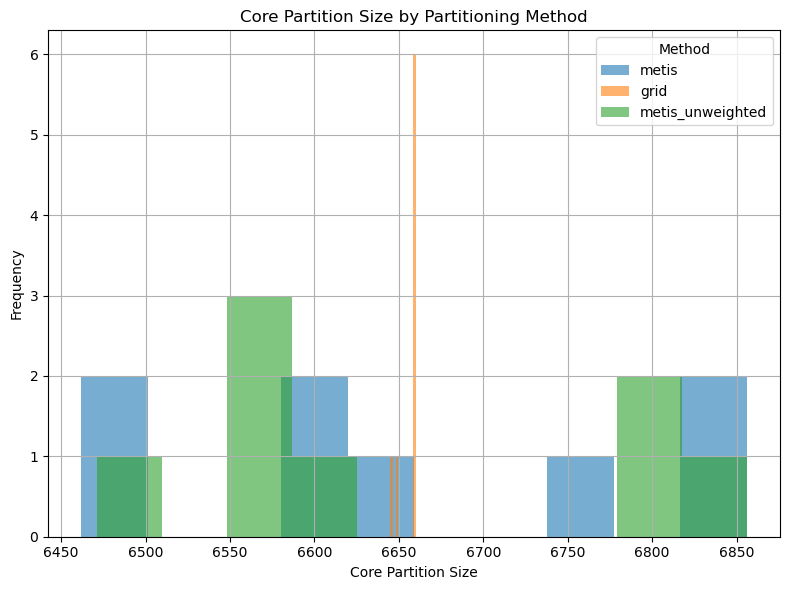

In [11]:
methods = partition_df['method'].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']  # Add more if needed
bins = 10

plt.figure(figsize=(8, 6))

for method, color in zip(methods, colors):
    subset = partition_df[partition_df['method'] == method]['core_n']
    plt.hist(subset, bins=bins, alpha=0.6, label=method, color=color)

plt.title("Core Partition Size by Partitioning Method")
plt.xlabel("Core Partition Size")
plt.ylabel("Frequency")
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.show()

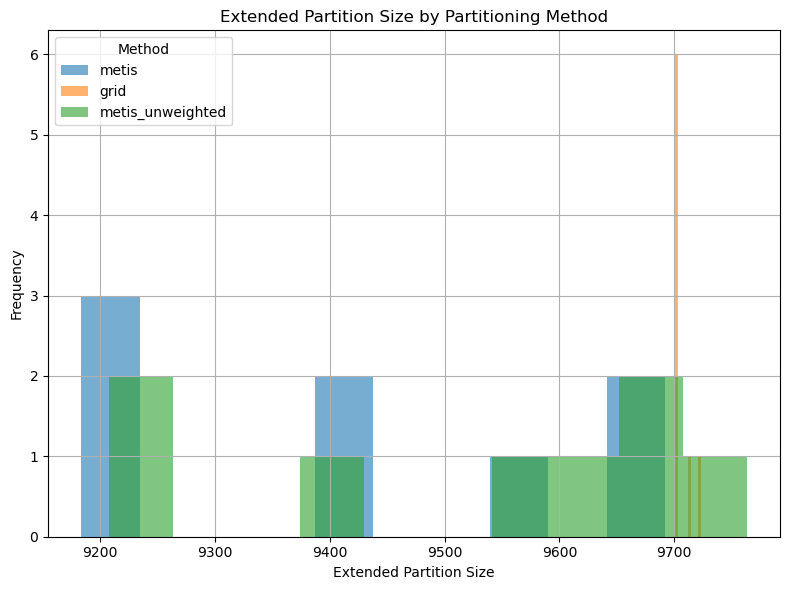

In [12]:
methods = partition_df['method'].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']  # Add more if needed
bins = 10

plt.figure(figsize=(8, 6))

for method, color in zip(methods, colors):
    subset = partition_df[partition_df['method'] == method]['n']
    plt.hist(subset, bins=bins, alpha=0.6, label=method, color=color)

plt.title("Extended Partition Size by Partitioning Method")
plt.xlabel("Extended Partition Size")
plt.ylabel("Frequency")
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.show()

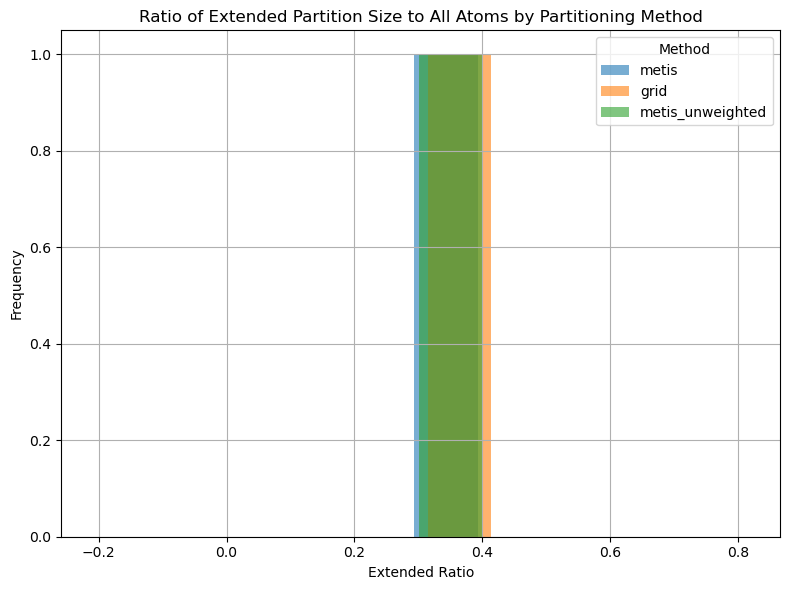

In [13]:
methods = all_df['method'].unique()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']  # Add more if needed
bins = 10

plt.figure(figsize=(8, 6))

for method, color in zip(methods, colors):
    subset = all_df[all_df['method'] == method]['extended_ratio']
    plt.hist(subset, bins=bins, alpha=0.6, label=method, color=color)

plt.title("Ratio of Extended Partition Size to All Atoms by Partitioning Method")
plt.xlabel("Extended Ratio")
plt.ylabel("Frequency")
plt.legend(title="Method")
plt.grid(True)
plt.tight_layout()
plt.show()